In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Le fichier <a href='http://qa.epidemium.cc/data/mortality_dataset/2017-25-10_mortality/mortality.csv'>Mortality.txt</a> contient les informations sur le nombre de décès par type de cancer, sex, tranche d'age et par pays. Les colonnes correspondantes sont :
- Nb_deaths
- Cancer_code
- Sex
- Age_bucket
- Location
- Year

En complément, les descriptions pour les codes sont fournies dans les fichiers :
- tranches d'age : <a href='http://qa.epidemium.cc/data/mortality_dataset/2017-25-10_mortality/age.txt'>age.txt</a>
- codes cancer : <a href='http://qa.epidemium.cc/data/mortality_dataset/2017-25-10_mortality/cancer_codes.csv'>cancer_codes.txt</a>

Le fichier <a href='http://qa.epidemium.cc/data/epidemiology_dataset/world_bank_data/WorldBank_Data.csv'>WorldBank_Data.csv</a>  contient les colonnes : 
- area_code : code du pays / de la region
- area : nom du pays / de la region
- year : année pour laquelle les indicateurs sont calculés

Les autres colonnes de 3 à 875 représentes les différents indicateurs. Leurs libellés complètes, ainsi que les méthodologies de calcul respectives sont détaillés dans un fichier complémentaire, <a href='http://qa.epidemium.cc/data/epidemiology_dataset/world_bank_data/WorldBank_Indicators.csv' target='_blank'>WorldBank_Indicators.csv</a> 

Pour construir notre base de modélisation, on souhaite joindre ces deux bases. Pour cela, certaines retraitements seront nécessaires : 
#### Modifications sur la base Mortality :
1 - modifications sur le découpage par tranches d'age pour harmoniser avec la base WorldBank

2 - modifications sur les noms des pays pour pour harmoniser avec la base WorldBank

#### Modifications sur la base WorldBank :
1 - modifications sur les codes sexe et tranches d'ages pour harmoniser avec la base Mortality

2 - remplacement des valeurs manquantes

<i>Un schéma qui résume les jointures et les transformations se trouve à la fin de ce notebook.</i>

In [2]:
#lecture base de données Mortality brute
df_mort= pd.read_table('mortality.txt',delimiter=';',names=['Cancer_code', 'Sex', 'Age_bucket', 'Location', 'Year', 'Nb_deaths'],low_memory=False)
df_mort.describe()

,Sex,Age_bucket,Year,Nb_deaths
count,6.359642e+06,6.359642e+06,6.359642e+06,6.359642e+06
mean,1.540061e+00,1.000000e+01,1.992326e+03,3.230369e+01
std,6.528709e-01,5.477226e+00,1.609652e+01,2.649799e+02
min,1.000000e+00,1.000000e+00,1.950000e+03,0.000000e+00
25%,1.000000e+00,5.000000e+00,1.981000e+03,0.000000e+00
50%,2.000000e+00,1.000000e+01,1.996000e+03,0.000000e+00
75%,2.000000e+00,1.500000e+01,2.006000e+03,5.000000e+00
max,9.000000e+00,1.900000e+01,2.015000e+03,3.493500e+04


In [3]:
df_mort.tail()

,Cancer_code,Sex,Age_bucket,Location,Year,Nb_deaths
6359637,C32,2,15,Spain,1988,7
6359638,C32,2,16,Spain,1988,5
6359639,C32,2,17,Spain,1988,9
6359640,C32,2,18,Spain,1988,10
6359641,C32,2,19,Spain,1988,0


In [4]:
#lecture du fichier WorldBank brut
df_wb = pd.read_csv('WorldBank_Data.csv', sep=',')

In [5]:
df_wb.head()

,area_code,area,year,SE.ADT.1524.LT.FE.ZS,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.MA.ZS,SE.ADT.1524.LT.ZS,SE.ADT.LITR.FE.ZS,SE.ADT.LITR.MA.ZS,SE.ADT.LITR.ZS,...,SL.UEM.TOTL.FE.ZS,SL.UEM.TOTL.MA.NE.ZS,SL.UEM.TOTL.MA.ZS,SL.UEM.TOTL.NE.ZS,SL.UEM.TOTL.ZS,SM.POP.NETM,SM.POP.REFG,SM.POP.REFG.OR,SM.POP.TOTL,SM.POP.TOTL.ZS
0,ABW,Aruba,1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7466.0,NaN
1,ABW,Aruba,1971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABW,Aruba,1972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-3537.0,NaN,NaN,NaN,NaN
3,ABW,Aruba,1973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABW,Aruba,1974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_wb.describe()

,year,SE.ADT.1524.LT.FE.ZS,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.MA.ZS,SE.ADT.1524.LT.ZS,SE.ADT.LITR.FE.ZS,SE.ADT.LITR.MA.ZS,SE.ADT.LITR.ZS,SE.COM.DURS,SE.ENR.PRIM.FM.ZS,...,SL.UEM.TOTL.FE.ZS,SL.UEM.TOTL.MA.NE.ZS,SL.UEM.TOTL.MA.ZS,SL.UEM.TOTL.NE.ZS,SL.UEM.TOTL.ZS,SM.POP.NETM,SM.POP.REFG,SM.POP.REFG.OR,SM.POP.TOTL,SM.POP.TOTL.ZS
count,11648.000000,947.000000,947.000000,947.000000,948.000000,960.000000,960.000000,962.000000,3680.000000,8498.000000,...,5746.000000,3882.000000,5746.000000,4576.000000,5746.000000,2.120000e+03,5.115000e+03,5.790000e+03,2.418000e+03,1512.000000
mean,1992.588341,85.378596,0.934534,89.704750,87.513374,75.049067,83.935035,79.467130,9.119293,0.911953,...,10.768031,7.566557,8.117224,8.129132,8.948894,-3.019128e+05,9.320643e+05,6.906962e+05,5.387660e+06,9.293558
std,13.300837,20.738517,0.131837,14.318209,17.445111,24.744161,17.348042,20.898257,2.021738,0.139949,...,8.020582,5.343605,5.487767,5.839693,6.032945,2.591169e+06,2.437202e+06,2.145572e+06,1.716141e+07,14.144178
min,1970.000000,6.664060,0.243310,22.377130,14.377520,3.182770,13.512920,8.685150,0.000000,0.000000,...,0.078000,0.020000,0.067000,0.050000,0.100000,-2.272986e+07,0.000000e+00,0.000000e+00,1.410000e+02,0.032596
25%,1981.000000,78.181570,0.914230,85.698850,82.236640,59.468830,76.291872,68.053309,8.000000,0.861855,...,5.391250,3.980000,4.604697,4.254689,5.047000,-1.797048e+05,9.425000e+02,7.425000e+01,3.738025e+04,1.358533
50%,1993.000000,96.298560,0.998440,96.530540,96.320067,85.465500,90.093645,87.845605,9.000000,0.971250,...,8.146000,6.525000,6.662949,6.910000,7.285000,-1.301300e+04,1.913100e+04,2.302500e+03,2.335015e+05,3.520657
75%,2004.000000,99.083780,1.002130,99.010885,98.992157,94.371780,96.962153,95.530375,10.000000,0.994340,...,14.113000,9.537500,10.154000,10.372500,11.518595,3.210350e+04,3.315095e+05,1.169018e+05,1.765247e+06,10.461212
max,2016.000000,100.000000,1.241410,100.000000,100.000000,99.999030,99.999470,99.999240,16.000000,1.507350,...,61.223000,54.599998,36.959000,59.500000,39.299999,2.268664e+07,2.138803e+07,2.138803e+07,2.431927e+08,88.404048


In [7]:
#fichier détaillant le mode de calcul des indicateurs WorldBank
df_wb_info = pd.read_csv('WorldBank_Indicators.csv', sep=',')
df_wb_info.head()

,Category,Subcategory,Code,Indicator Name,Long definition,Source
0,Economie,National_accounts&Official_development_assista...,DC.DAC.AUSL.CD,"Net bilateral aid flows from DAC donors, Austr...",Net bilateral aid flows from DAC donors are th...,Development Assistance Committee of the Organi...
1,Economie,National_accounts&Official_development_assista...,DC.DAC.AUTL.CD,"Net bilateral aid flows from DAC donors, Austr...",Net bilateral aid flows from DAC donors are th...,Development Assistance Committee of the Organi...
2,Economie,National_accounts&Official_development_assista...,DC.DAC.BELL.CD,"Net bilateral aid flows from DAC donors, Belgi...",Net bilateral aid flows from DAC donors are th...,Development Assistance Committee of the Organi...
3,Economie,National_accounts&Official_development_assista...,DC.DAC.CANL.CD,"Net bilateral aid flows from DAC donors, Canad...",Net bilateral aid flows from DAC donors are th...,Development Assistance Committee of the Organi...
4,Economie,National_accounts&Official_development_assista...,DC.DAC.CECL.CD,"Net bilateral aid flows from DAC donors, Europ...",Net bilateral aid flows from DAC donors are th...,Development Assistance Committee of the Organi...


<u> 1 - Modifications sur le découpage par tranches d'age pour harmoniser avec la base WorldBank</u>


Le découpage par tranches d'age de l'indicateur mortalité dans la base Mortality ne correspond pas avec l'indicateur de la population de la base 'WorldBank'. On fait donc une harmonisation entre ces deux : 
- aggregation de la tranche d'age 16 et suppression des tranches d'age 17,18 et 19

In [8]:
#découpage des ages pour l'indicateur mortalité
print("Classes d'age dans base Mortality : ", df_mort.Age_bucket.unique())
df_age = pd.read_csv('age.csv', header = None , sep=' ')
df_age.columns=['Age_bucket', 'Age']
print("Décodage des tranches d'age dans la base Mortality : ")
df_age

Classes d'age dans base Mortality :  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Décodage des tranches d'age dans la base Mortality : 


,Age_bucket,Age
0,1,0-4
1,2,5-9
2,3,10-14
3,4,15-19
4,5,20-24
5,6,25-29
6,7,30-34
7,8,35-39
8,9,40-44
9,10,45-49


In [9]:
#découpage des ages pour l'indicateur population
print("Variables d'age dans la base WorldBank : ")
print(df_wb.columns[df_wb.columns.str.startswith('SP.POP')])

Variables d'age dans la base WorldBank : 
Index(['SP.POP.0004.FE.5Y', 'SP.POP.0004.MA.5Y', 'SP.POP.0014.TO.ZS',
       'SP.POP.0509.FE.5Y', 'SP.POP.0509.MA.5Y', 'SP.POP.1014.FE.5Y',
       'SP.POP.1014.MA.5Y', 'SP.POP.1519.FE.5Y', 'SP.POP.1519.MA.5Y',
       'SP.POP.1564.TO.ZS', 'SP.POP.2024.FE.5Y', 'SP.POP.2024.MA.5Y',
       'SP.POP.2529.FE.5Y', 'SP.POP.2529.MA.5Y', 'SP.POP.3034.FE.5Y',
       'SP.POP.3034.MA.5Y', 'SP.POP.3539.FE.5Y', 'SP.POP.3539.MA.5Y',
       'SP.POP.4044.FE.5Y', 'SP.POP.4044.MA.5Y', 'SP.POP.4549.FE.5Y',
       'SP.POP.4549.MA.5Y', 'SP.POP.5054.FE.5Y', 'SP.POP.5054.MA.5Y',
       'SP.POP.5559.FE.5Y', 'SP.POP.5559.MA.5Y', 'SP.POP.6064.FE.5Y',
       'SP.POP.6064.MA.5Y', 'SP.POP.6569.FE.5Y', 'SP.POP.6569.MA.5Y',
       'SP.POP.65UP.TO.ZS', 'SP.POP.7074.FE.5Y', 'SP.POP.7074.MA.5Y',
       'SP.POP.7579.FE.5Y', 'SP.POP.7579.MA.5Y', 'SP.POP.80UP.FE.5Y',
       'SP.POP.80UP.MA.5Y', 'SP.POP.DPND', 'SP.POP.DPND.OL', 'SP.POP.DPND.YG',
       'SP.POP.GROW', 'SP.POP.TOTL', 'S

In [10]:
length=len(df_mort[df_mort['Age_bucket']==16])
index=df_mort[df_mort['Age_bucket']==16]['Nb_deaths'].index
j=list(range(0, length, 1))
t_16=df_mort[df_mort['Age_bucket']==16]['Nb_deaths'].values
t_17=df_mort[df_mort['Age_bucket']==17]['Nb_deaths'].values
t_18=df_mort[df_mort['Age_bucket']==18]['Nb_deaths'].values
t_19=df_mort[df_mort['Age_bucket']==19]['Nb_deaths'].values
df_mort['Nb_deaths'][index]=t_16[j] + t_17[j] + t_18[j] + t_19[j]

index17_18_19=df_mort[(df_mort['Age_bucket']==17) | (df_mort['Age_bucket']==18) | (df_mort['Age_bucket']==19)]['Nb_deaths'].index
df_mort=df_mort.drop(df_mort.index[index17_18_19])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
#harmonisation codes cancer
df_mort.replace(['C33, C34'], ['C33,C34'], inplace=True)

<u>2 - Modifications sur les noms des pays pour pour harmoniser avec la base WorldBank</u>

La base WorldBank ne dispose pas des codes des pays, seuls les libellés sont présents. On est donc obligées de faire la jointure avec la base Mortality avec les libellés comme clé. Pour cela, on a vérifié les pays et on a modifié manuellement les libellés pour avoir une correspondance entre les pays en commun. 

Ainsi, dans le fichier 'correspondance.txt', on a : 
- area : libellé du pays sous la forme originale trouvée dans WorldBank
- area2 : libellé du pays corrigé manuellement pour trouver la correspondance entre WorldBank et Mortality

Par la suite, la jointure entre les deux bases se fera sur la clé area2 au lieu de area.

On a décidé de faire un inner join entre ces deux base, ce qui élimine 23 pays de la base Mortality absents de la base WorldBank (après avoir vérifié et corrigé les problèmes de mismatch des libellés). Ce sont pour la plupart des iles, des pays qui n'exitent plus, ou encore des zones qui représentent des regroupements de pays.


In [12]:
print('Nombre pays dans base Mortality: ', len(df_mort.Location.unique()))
print('Nombre pays dans base WorldBank: ', len(df_wb.area.unique()))

Nombre pays dans base Mortality:  153
Nombre pays dans base WorldBank:  258


In [13]:
#lecture fichier avec noms des pays corrigés manuellement
df_correspondance=pd.read_table('correspondance.txt',delimiter=';')
df_correspondance.tail(15)

,area,area2
243,United Arab Emirates,
244,United Kingdom,United Kingdom
245,United States,United States of America
246,Upper middle income,
247,Uruguay,Uruguay
248,Uzbekistan,Uzbekistan
249,Vanuatu,
250,"Venezuela, RB",Venezuela
251,Vietnam,
252,Virgin Islands (U.S.),Virgin Islands (USA)


In [14]:
# on crée une nouvelle colonne "area2" dane la base worldbank qui correspond au nom du pays dans la base mortality
df_wb = pd.merge(df_wb, df_correspondance, on='area', how='left')
df_wb.head()

,area_code,area,year,SE.ADT.1524.LT.FE.ZS,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.MA.ZS,SE.ADT.1524.LT.ZS,SE.ADT.LITR.FE.ZS,SE.ADT.LITR.MA.ZS,SE.ADT.LITR.ZS,...,SL.UEM.TOTL.MA.NE.ZS,SL.UEM.TOTL.MA.ZS,SL.UEM.TOTL.NE.ZS,SL.UEM.TOTL.ZS,SM.POP.NETM,SM.POP.REFG,SM.POP.REFG.OR,SM.POP.TOTL,SM.POP.TOTL.ZS,area2
0,ABW,Aruba,1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7466.0,NaN,Aruba
1,ABW,Aruba,1971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aruba
2,ABW,Aruba,1972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-3537.0,NaN,NaN,NaN,NaN,Aruba
3,ABW,Aruba,1973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aruba
4,ABW,Aruba,1974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aruba


La variable Mortality de notre base représente un nombre (absolut) de déces; nous voulons la transformer en taux de mortalité pour pouvoir faire une comparaison entre les pays. 

Pour ce faire, il faudra utiliser les variables de population par tranches d'age et par sexe de la base WorldBank, que nous transformerions en variables distinctes.

La mortalité sera donc le nombre de déces divisé par la population. Le taux sera sur 100 000, comme calculé par les organismes de spécialité (<a href='http://www.who.int/mediacentre/factsheets/fs297/en/'>WHO</a>  ,<a href='https://www.cancer.gov/about-cancer/understanding/statistics'> National Cancer Institute USA</a> )

In [15]:
#naming convention = old name without the .5Y at the end and without the SP in the beginning
pop_par_tranche_dage=['POP.0004.','POP.0509.','POP.1014.','POP.1519.','POP.2024.','POP.2529.','POP.3034.','POP.3539.','POP.4044.','POP.4549.','POP.5054.','POP.5559.','POP.6064.','POP.6569.','POP.7074.','POP.7579.','POP.80UP.']
for i in range(0,17):
    df_wb[''+pop_par_tranche_dage[i]+'FE'] =(df_wb['SP.POP.TOTL']*df_wb['SP.POP.TOTL.FE.ZS']*df_wb['SP.'+pop_par_tranche_dage[i]+'FE.5Y'])/10000
    df_wb[''+pop_par_tranche_dage[i]+'MA'] =(df_wb['SP.POP.TOTL']*(100-df_wb['SP.POP.TOTL.FE.ZS'])*df_wb['SP.'+pop_par_tranche_dage[i]+'MA.5Y'])/10000

In [16]:
#extraire les colonnes sur la population de la base WorldBank
df_mini = df_wb[['area','year','POP.0004.FE', 'POP.0509.FE', 'POP.1014.FE', 'POP.1519.FE', 'POP.2024.FE', 'POP.2529.FE', 'POP.3034.FE', 'POP.3539.FE', 'POP.4044.FE', 'POP.4549.FE', 'POP.5054.FE', 'POP.5559.FE', 'POP.6064.FE', 'POP.6569.FE', 'POP.7074.FE', 'POP.7579.FE', 'POP.80UP.FE', 'POP.0004.MA', 'POP.0509.MA', 'POP.1014.MA', 'POP.1519.MA', 'POP.2024.MA', 'POP.2529.MA', 'POP.3034.MA', 'POP.3539.MA', 'POP.4044.MA', 'POP.4549.MA', 'POP.5054.MA', 'POP.5559.MA', 'POP.6064.MA', 'POP.6569.MA', 'POP.7074.MA', 'POP.7579.MA', 'POP.80UP.MA']]
df_mini.head()

,area,year,POP.0004.FE,POP.0509.FE,POP.1014.FE,POP.1519.FE,POP.2024.FE,POP.2529.FE,POP.3034.FE,POP.3539.FE,...,POP.3539.MA,POP.4044.MA,POP.4549.MA,POP.5054.MA,POP.5559.MA,POP.6064.MA,POP.6569.MA,POP.7074.MA,POP.7579.MA,POP.80UP.MA
0,Aruba,1970,3434.0,3793.0,3586.0,3365.0,2879.0,2302.0,1946.0,1915.0,...,1544.0,1316.0,1175.0,1056.0,943.0,886.0,524.0,295.0,144.0,76.0
1,Aruba,1971,3218.0,3713.0,3578.0,3365.0,2975.0,2415.0,2003.0,1955.0,...,1602.0,1348.0,1172.0,1051.0,930.0,895.0,579.0,320.0,160.0,85.0
2,Aruba,1972,3109.0,3574.0,3580.0,3343.0,3043.0,2531.0,2076.0,1973.0,...,1655.0,1393.0,1174.0,1044.0,924.0,881.0,640.0,345.0,178.0,95.0
3,Aruba,1973,3075.0,3374.0,3585.0,3311.0,3078.0,2648.0,2160.0,1980.0,...,1704.0,1449.0,1188.0,1033.0,922.0,854.0,700.0,371.0,197.0,107.0
4,Aruba,1974,3045.0,3143.0,3563.0,3289.0,3082.0,2754.0,2250.0,2000.0,...,1755.0,1512.0,1214.0,1025.0,921.0,827.0,743.0,405.0,216.0,121.0


In [17]:
#transformation pour avoir une seule variable Population éclatée par pays, année, age, sex
df_mini.set_index(['area', 'year'], inplace=True)
df_mini.columns = pd.MultiIndex.from_tuples(tuple(df_mini.columns.str.split(".")))

df_pop = df_mini.stack(level = [1,2]).reset_index()
df_pop.columns = ['Country', 'Year', 'Age_group', 'Sex', 'Population']
df_pop.head()

,Country,Year,Age_group,Sex,Population
0,Aruba,1970,0004,FE,3434.0
1,Aruba,1970,0004,MA,3578.0
2,Aruba,1970,0509,FE,3793.0
3,Aruba,1970,0509,MA,3943.0
4,Aruba,1970,1014,FE,3586.0


In [18]:
#remplacer les codes pour le sex et pour les tranches d'age, pour harmoniser les deux bases
df_pop['Sex'].replace(['MA', 'FE'],[1,2], inplace=True)
df_pop['Age_group'].replace(['0004','0509','1014','1519','2024','2529','3034','3539','4044','4549','5054','5559','6064','6569','7074','7579'],
list(range(1, 17)), inplace=True)

In [19]:
#jointure entre la base Mortality et la base transformée avec la population
df_mort = pd.merge(df_mort, 
              df_pop, 
              how='inner', 
              left_on=['Location', 'Year', 'Age_bucket', 'Sex'], 
              right_on=['Country', 'Year', 'Age_group', 'Sex'])
df_mort.head()

,Cancer_code,Sex,Age_bucket,Location,Year,Nb_deaths,Country,Age_group,Population
0,C80,2,1,Jamaica,2000,2,Jamaica,1,139549.999999
1,C56,2,1,Jamaica,2000,0,Jamaica,1,139549.999999
2,C64,2,1,Jamaica,2000,1,Jamaica,1,139549.999999
3,C44,2,1,Jamaica,2000,0,Jamaica,1,139549.999999
4,C84,2,1,Jamaica,2000,0,Jamaica,1,139549.999999


In [20]:
#calculer la mortalité comme taux
df_mort['Mortality_rate'] = df_mort['Nb_deaths'] / df_mort['Population'] * 10**5
df_mort['Mortality_rate'].describe()

count    3.652496e+06
mean     1.098289e+01
std      6.163104e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.171180e+00
max      8.091666e+03
Name: Mortality_rate, dtype: float64

In [21]:
df_mort.head(3)

,Cancer_code,Sex,Age_bucket,Location,Year,Nb_deaths,Country,Age_group,Population,Mortality_rate
0,C80,2,1,Jamaica,2000,2,Jamaica,1,139549.999999,1.433178
1,C56,2,1,Jamaica,2000,0,Jamaica,1,139549.999999,0.000000
2,C64,2,1,Jamaica,2000,1,Jamaica,1,139549.999999,0.716589


### Choix des indicateurs socio-économiques
On remarque que beaucoup des indicateurs socio-économiques ont une proportion de valeurs manquantes très importante, donc on souhaite ne conserver que ceux pour lesquels le pourcentage de données renseignées est satisfaisant, par exemple au moins 75% des valeurs remplies. 

In [22]:
cutoff = 0.25 #seuil de pourcentage valeurs manquantes acceptées
nb_na = df_wb.isnull().sum() #calculer nombre de valeurs manquantes par colonne
df_na = pd.DataFrame({'indicator':nb_na.index, 'na_nb':nb_na.values}) 
df_na.sort_values(by=['na_nb'], ascending=False, inplace=True) 
df_na['na_pct'] = df_na['na_nb'] / df_wb.shape[0] #calculer pourcentage de valeurs manquantes

In [23]:
#visualiser indicateurs par ordre croissante de valeurs présentes
df_indic_info = pd.merge(left=df_wb_info, right=df_na, 
                         how = 'left',
                         left_on = 'Code', right_on = 'indicator')
df_indic_info[df_indic_info['na_pct'] < cutoff][['Category','Code', 'Indicator Name', 'Long definition','na_pct']].sort_values(by=['na_pct'], ascending=True)

,Category,Code,Indicator Name,Long definition,na_pct
507,Environnement,SP.URB.TOTL.IN.ZS,Urban population (% of total),Urban population refers to people living in ur...,0.004808
504,Environnement,SP.RUR.TOTL.ZS,Rural population (% of total population),Rural population refers to people living in ru...,0.004808
502,Environnement,SP.RUR.TOTL,Rural population,Rural population refers to people living in ru...,0.005065
645,Health,SP.POP.TOTL,"Population, total",Total population is based on the de facto defi...,0.005065
506,Environnement,SP.URB.TOTL,Urban population,Urban population refers to people living in ur...,0.005065
505,Environnement,SP.URB.GROW,Urban population growth (annual %),Urban population refers to people living in ur...,0.005237
644,Health,SP.POP.GROW,Population growth (annual %),Annual population growth rate for year t is th...,0.005409
267,Education,SE.PRM.DURS,"Primary education, duration (years)",Primary duration refers to the number of grade...,0.010903
406,Environnement,AG.SRF.TOTL.K2,Surface area (sq. km),"Surface area is a country's total area, includ...",0.013565
398,Environnement,AG.LND.TOTL.K2,Land area (sq. km),"Land area is a country's total area, excluding...",0.013994


Notre sélection d'indicateurs :

<table><tr><th>Category</th><th>Indicator code</th><th>Indicator Name</th></tr><tr><td>Education</td><td>SE.PRM.DURS</td><td>Primary education, duration (years)</td></tr><tr><td>Education</td><td>SE.PRE.DURS</td><td>Preprimary education, duration (years)</td></tr><tr><td>Education</td><td>SE.SEC.DURS</td><td>Secondary education, duration (years)</td></tr><tr><td>Environnement</td><td>SP.URB.TOTL.IN.ZS</td><td>Urban population (% of total)</td></tr><tr><td>Environnement</td><td>SP.URB.GROW</td><td>Urban population growth (annual %)</td></tr><tr><td>Environnement</td><td>AG.SRF.TOTL.K2</td><td>Surface area (sq. km)</td></tr><tr><td>Environnement</td><td>EN.POP.DNST</td><td>Population density (people per sq. km of land area)</td></tr><tr><td>Environnement</td><td>EN.ATM.NOXE.KT.CE</td><td>Nitrous oxide emissions (thousand metric tons of CO2 equivalent)</td></tr><tr><td>Environnement</td><td>EN.ATM.METH.KT.CE</td><td>Methane emissions (kt of CO2 equivalent)</td></tr><tr><td>Environnement</td><td>AG.LND.AGRI.K2</td><td>Agricultural land (sq. km)</td></tr><tr><td>Environnement</td><td>EN.ATM.GHGO.KT.CE</td><td>Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)</td></tr><tr><td>Environnement</td><td>AG.LND.AGRI.ZS</td><td>Agricultural land (% of land area)</td></tr><tr><td>Environnement</td><td>AG.PRD.FOOD.XD</td><td>Food production index (2004-2006 = 100)</td></tr><tr><td>Environnement</td><td>AG.PRD.LVSK.XD</td><td>Livestock production index (2004-2006 = 100)</td></tr><tr><td>Environnement</td><td>AG.PRD.CROP.XD</td><td>Crop production index (2004-2006 = 100)</td></tr><tr><td>Environnement</td><td>EN.ATM.GHGT.KT.CE</td><td>Total greenhouse gas emissions (kt of CO2 equivalent)</td></tr><tr><td>Environnement</td><td>EN.ATM.CO2E.GF.ZS</td><td>CO2 emissions from gaseous fuel consumption (% of total)</td></tr><tr><td>Environnement</td><td>EN.ATM.CO2E.LF.ZS</td><td>CO2 emissions from liquid fuel consumption (% of total)</td></tr><tr><td>Environnement</td><td>EN.ATM.CO2E.SF.ZS</td><td>CO2 emissions from solid fuel consumption (% of total)</td></tr><tr><td>Environnement</td><td>NY.GDP.FRST.RT.ZS</td><td>Forest rents (% of GDP)</td></tr><tr><td>Environnement</td><td>NY.GDP.MINR.RT.ZS</td><td>Mineral rents (% of GDP)</td></tr><tr><td>Environnement</td><td>EN.ATM.CO2E.LF.KT</td><td>CO2 emissions from liquid fuel consumption (kt)</td></tr><tr><td>Environnement</td><td>EN.ATM.METH.AG.KT.CE</td><td>Agricultural methane emissions (thousand metric tons of CO2 equivalent)</td></tr><tr><td>Environnement</td><td>EN.ATM.METH.EG.KT.CE</td><td>Methane emissions in energy sector (thousand metric tons of CO2 equivalent)</td></tr><tr><td>Environnement</td><td>EN.ATM.NOXE.AG.KT.CE</td><td>Agricultural nitrous oxide emissions (thousand metric tons of CO2 equivalent)</td></tr><tr><td>Environnement</td><td>EN.ATM.NOXE.EG.KT.CE</td><td>Nitrous oxide emissions in energy sector (thousand metric tons of CO2 equivalent)</td></tr><tr><td>Environnement</td><td>NY.GDP.TOTL.RT.ZS</td><td>Total natural resources rents (% of GDP)</td></tr><tr><td>Environnement</td><td>EN.ATM.CO2E.KT</td><td>CO2 emissions (kt)</td></tr><tr><td>Environnement</td><td>EN.ATM.CO2E.PC</td><td>CO2 emissions (metric tons per capita)</td></tr><tr><td>Health</td><td>SP.POP.GROW</td><td>Population growth (annual %)</td></tr><tr><td>Health</td><td>SP.DYN.CBRT.IN</td><td>Birth rate, crude (per 1,000 people)</td></tr><tr><td>Health</td><td>SP.DYN.CDRT.IN</td><td>Death rate, crude (per 1,000 people)</td></tr><tr><td>Health</td><td>SP.DYN.TFRT.IN</td><td>Fertility rate, total (births per woman)</td></tr><tr><td>Health</td><td>SP.ADO.TFRT</td><td>Adolescent fertility rate (births per 1,000 women ages 15-19)</td></tr><tr><td>Health</td><td>SP.DYN.LE00.FE.IN</td><td>Life expectancy at birth, female (years)</td></tr><tr><td>Health</td><td>SP.DYN.LE00.IN</td><td>Life expectancy at birth, total (years)</td></tr><tr><td>Health</td><td>SP.POP.DPND</td><td>Age dependency ratio (% of working-age population)</td></tr><tr><td>Health</td><td>SP.DYN.AMRT.FE</td><td>Mortality rate, adult, female (per 1,000 female adults)</td></tr><tr><td>Health</td><td>SP.DYN.AMRT.MA</td><td>Mortality rate, adult, male (per 1,000 male adults)</td></tr><tr><td>Infrastructure</td><td>IT.CEL.SETS</td><td>Mobile cellular subscriptions</td></tr><tr><td>Infrastructure</td><td>IT.MLT.MAIN</td><td>Fixed telephone subscriptions</td></tr><tr><td>National_accounts</td><td>NY.ADJ.AEDU.GN.ZS</td><td>Adjusted savings: education expenditure (% of GNI)</td></tr><tr><td>National_accounts</td><td>NY.GDP.MKTP.CD</td><td>GDP (current USD)</td></tr><tr><td>National_accounts</td><td>NY.GDP.PCAP.CD</td><td>GDP per capita (current USD)</td></tr>
</table>

## Remplacement des valeurs manquantes
Pour les valeurs manquantes restantes de nos indicateurs socio-économiques séléctionnés, on les remplacera avec les valeurs des années disponibles.

In [24]:
#séléction indicateurs
indicators = ['area','year','SP.URB.TOTL.IN.ZS',	'SP.URB.GROW',	'SP.POP.GROW',	'SE.PRM.DURS',	'AG.SRF.TOTL.K2',	'SE.PRE.DURS',	'EN.POP.DNST',	'SE.SEC.DURS',	'SP.DYN.CBRT.IN',	'SP.DYN.CDRT.IN',	'NY.ADJ.AEDU.GN.ZS',	'SP.DYN.TFRT.IN',	'SP.ADO.TFRT',	'SP.DYN.LE00.FE.IN',	'SP.DYN.LE00.IN',	'SP.POP.DPND',	'SP.DYN.AMRT.FE',	'SP.DYN.AMRT.MA',	'EN.ATM.NOXE.KT.CE',	'EN.ATM.METH.KT.CE',	'AG.LND.AGRI.K2',	'EN.ATM.GHGO.KT.CE',	'AG.LND.AGRI.ZS',	'AG.PRD.FOOD.XD',	'IT.CEL.SETS',	'AG.PRD.LVSK.XD',	'AG.PRD.CROP.XD',	'IT.MLT.MAIN',	'EN.ATM.GHGT.KT.CE',	'EN.ATM.CO2E.GF.ZS',	'EN.ATM.CO2E.LF.ZS',	'EN.ATM.CO2E.SF.ZS',	'NY.GDP.FRST.RT.ZS',	'NY.GDP.MINR.RT.ZS',	'EN.ATM.CO2E.LF.KT',	'EN.ATM.METH.AG.KT.CE',	'EN.ATM.METH.EG.KT.CE',	'EN.ATM.NOXE.AG.KT.CE',	'EN.ATM.NOXE.EG.KT.CE',	'NY.GDP.TOTL.RT.ZS',	'EN.ATM.CO2E.KT',	'EN.ATM.CO2E.PC',	'NY.GDP.MKTP.CD',	'NY.GDP.PCAP.CD']
df_wb = df_wb.loc[:,indicators]

#remplacement valeurs manquantes
df_wb=df_wb.groupby('area').apply(lambda x: (x.sort_values('year', ascending=True)))
df_wb.fillna(method='ffill',inplace=True)
df_wb.fillna(method='bfill',inplace=True)
df_wb.reset_index(drop=True,inplace=True)
df_wb.isnull().values.sum() #vérifier qu'il n'y a plus de valeurs manquantes

0

Enfin, on fait une jointure entre la base Mortality (qui contient maintenant la mortalité comme taux) et la base WorldBank avec les indicateurs socio-économiques

In [25]:
#jointure base de données complète avec toutes les années, tous les pays, tous les types de cancer
df=pd.merge(df_mort, 
              df_wb, 
              how='inner',
              left_on=['Location','Year'], 
         right_on=['area','year'])

#df.to_csv(path_or_buf = 'data_mort_wb.csv', sep=',', na_rep='')
df.head()

,Cancer_code,Sex,Age_bucket,Location,Year,Nb_deaths,Country,Age_group,Population,Mortality_rate,...,EN.ATM.CO2E.LF.KT,EN.ATM.METH.AG.KT.CE,EN.ATM.METH.EG.KT.CE,EN.ATM.NOXE.AG.KT.CE,EN.ATM.NOXE.EG.KT.CE,NY.GDP.TOTL.RT.ZS,EN.ATM.CO2E.KT,EN.ATM.CO2E.PC,NY.GDP.MKTP.CD,NY.GDP.PCAP.CD
0,C80,2,1,Jamaica,2000,2,Jamaica,1,139549.999999,1.433178,...,9856.896,633.005651,267.408083,361.597144,52.552558,1.762288,10307.937,3.964446,8.929376e+09,3434.249741
1,C56,2,1,Jamaica,2000,0,Jamaica,1,139549.999999,0.000000,...,9856.896,633.005651,267.408083,361.597144,52.552558,1.762288,10307.937,3.964446,8.929376e+09,3434.249741
2,C64,2,1,Jamaica,2000,1,Jamaica,1,139549.999999,0.716589,...,9856.896,633.005651,267.408083,361.597144,52.552558,1.762288,10307.937,3.964446,8.929376e+09,3434.249741
3,C44,2,1,Jamaica,2000,0,Jamaica,1,139549.999999,0.000000,...,9856.896,633.005651,267.408083,361.597144,52.552558,1.762288,10307.937,3.964446,8.929376e+09,3434.249741
4,C84,2,1,Jamaica,2000,0,Jamaica,1,139549.999999,0.000000,...,9856.896,633.005651,267.408083,361.597144,52.552558,1.762288,10307.937,3.964446,8.929376e+09,3434.249741


In [26]:
#vérification
print("Base de données complète : ")
print('- années incluses : ', np.sort(df.Year.unique()), '\n =>nb années :', len(df.Year.unique()))
print()
print('- pays inclus :', np.sort(df.Country.unique()), '\n =>nb pays :', len(df.Country.unique()) )
print()
print('- types de cancer inclus :', np.sort(df.Cancer_code.unique()), '\n =>nb types cancer :', len(df.Cancer_code.unique()) )

Base de données complète : 
- années incluses :  [1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999
 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015] 
 =>nb années : 46

- pays inclus : ['Albania' 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Australia'
 'Austria' 'Azerbaijan' 'Bahrain' 'Barbados' 'Belarus' 'Belgium' 'Belize'
 'Bolivia' 'Bosnia and Herzegovina' 'Brazil' 'Brunei Darussalam' 'Bulgaria'
 'Canada' 'Chile' 'Colombia' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus'
 'Czech Republic' 'Denmark' 'Dominican Republic' 'Ecuador' 'El Salvador'
 'Estonia' 'Fiji' 'Finland' 'France' 'Georgia' 'Germany' 'Greece' 'Grenada'
 'Guatemala' 'Guyana' 'Haiti' 'Honduras' 'Hungary' 'Iceland' 'Iraq'
 'Ireland' 'Israel' 'Italy' 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan'
 'Kiribati' 'Kuwait' 'Latvia' 'Lithuania' 'Luxembourg' 'Malaysia'
 'Maldives' 'Malta' 'Mauritius' 'Mex

Pour nos modélisations, nous travaillerons sur une base restreinte au cancer des poumons <b>à partir de l'année 2000.</b>

On choisit cette période à cause d'une rupture observée dans le trend général de la base de donnée dont on dispose; elle est plus prononcée pour certains pays que pour d'autres. 

Pour la période 2000 - 2015, le taux de mortalité semble avoir un trend descendant pour la plupart des pays (moins évident en France), donc on s'attend à ce que la variable Year soit significative dans nos modèles.

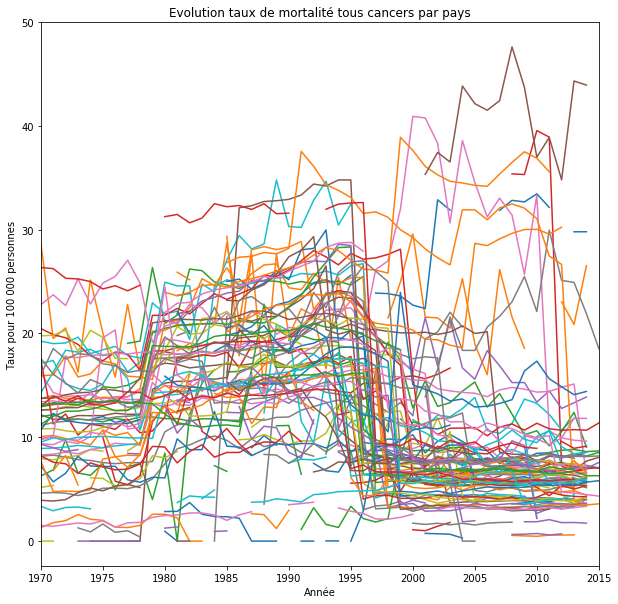

In [27]:
#graph taux de mortalité par pays, toutes tranches d'age confondues, tous types de cancers confondus
plt.figure()
df_mort.groupby([df.Year.name, df.Location.name])['Mortality_rate'].mean().unstack().plot(figsize=(10,10))
plt.legend().set_visible(False)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05) ) 
plt.title("Evolution taux de mortalité tous cancers par pays")
plt.xlabel('Année')
plt.ylabel('Taux pour 100 000 personnes')
plt.show()

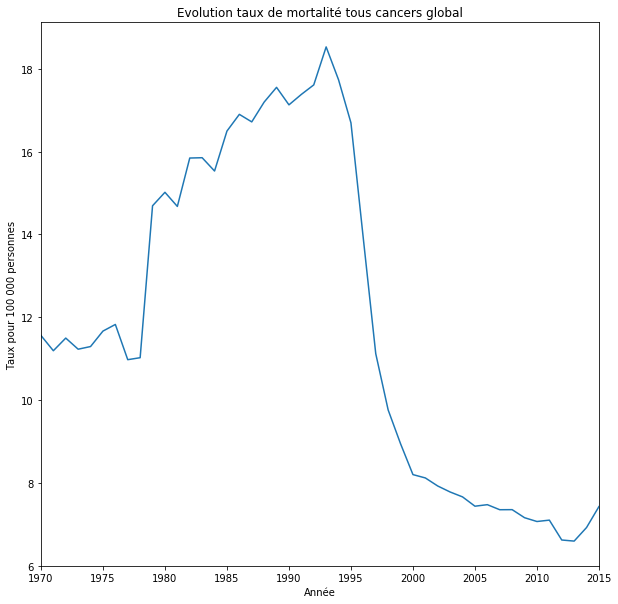

In [28]:
#graph taux de mortalité global, tous pays confondus, toutes tranches d'age confondues, tous types de cancers confondus, hommes et femmes
plt.figure()
df_mort.groupby([df.Year.name])['Mortality_rate'].mean().plot(figsize=(10,10))
plt.title("Evolution taux de mortalité tous cancers global")
plt.xlabel('Année')
plt.ylabel('Taux pour 100 000 personnes')
plt.show()

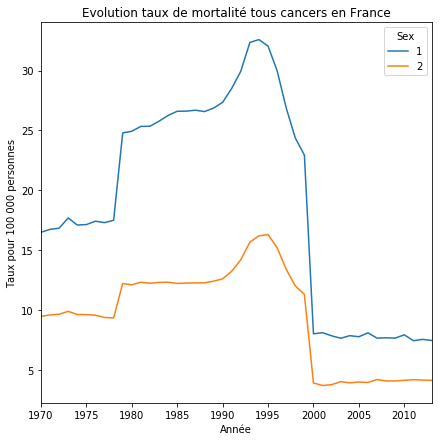

In [29]:
#graph taux de mortalité en France, toutes tranches d'age confondues, tous types de cancers confondus, par hommes et femmes
plt.figure()
df_mort[df_mort.Location=='France'].groupby([df.Year.name, df.Sex.name])['Mortality_rate'].mean().unstack().plot(figsize=(7,7)) 
plt.title("Evolution taux de mortalité tous cancers en France")
plt.xlabel('Année')
plt.ylabel('Taux pour 100 000 personnes')
plt.show()

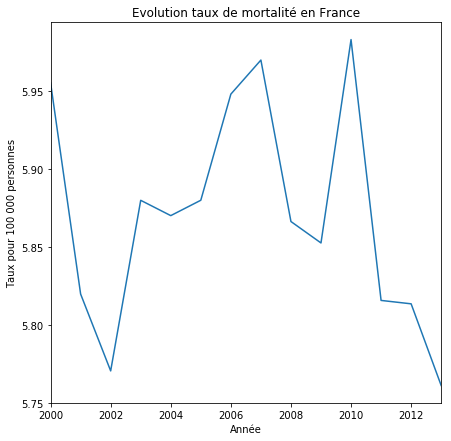

In [30]:
#graph taux de mortalité en France, toutes tranches d'age confondues, tous types de cancers confondus, hommes et femmes
plt.figure()
df_mort[(df_mort.Location=='France') & (df_mort.Year >=2000)].groupby([df.Year.name])['Mortality_rate'].mean().plot(figsize=(7,7)) 
plt.title("Evolution taux de mortalité en France")
plt.xlabel('Année')
plt.ylabel('Taux pour 100 000 personnes')
plt.show()

In [31]:
df_sub = df[(df['Year'] >= 2000) & (df['Cancer_code']=='C33,C34') ].copy()
df_sub.drop(['Cancer_code','Location','Nb_deaths','Age_group','Population','area','year'],inplace=True,axis=1)

df_sub.to_csv(path_or_buf = 'data_mort_wb_sub.csv', sep=',', na_rep='')
df_sub.head()

,Sex,Age_bucket,Year,Country,Mortality_rate,SP.URB.TOTL.IN.ZS,SP.URB.GROW,SP.POP.GROW,SE.PRM.DURS,AG.SRF.TOTL.K2,...,EN.ATM.CO2E.LF.KT,EN.ATM.METH.AG.KT.CE,EN.ATM.METH.EG.KT.CE,EN.ATM.NOXE.AG.KT.CE,EN.ATM.NOXE.EG.KT.CE,NY.GDP.TOTL.RT.ZS,EN.ATM.CO2E.KT,EN.ATM.CO2E.PC,NY.GDP.MKTP.CD,NY.GDP.PCAP.CD
40,2,1,2000,Jamaica,0.0,51.814,1.24118,0.776905,6.0,10990.0,...,9856.896,633.005651,267.408083,361.597144,52.552558,1.762288,10307.937,3.964446,8.929376e+09,3434.249741
85,2,2,2000,Jamaica,0.0,51.814,1.24118,0.776905,6.0,10990.0,...,9856.896,633.005651,267.408083,361.597144,52.552558,1.762288,10307.937,3.964446,8.929376e+09,3434.249741
130,2,3,2000,Jamaica,0.0,51.814,1.24118,0.776905,6.0,10990.0,...,9856.896,633.005651,267.408083,361.597144,52.552558,1.762288,10307.937,3.964446,8.929376e+09,3434.249741
175,2,4,2000,Jamaica,0.0,51.814,1.24118,0.776905,6.0,10990.0,...,9856.896,633.005651,267.408083,361.597144,52.552558,1.762288,10307.937,3.964446,8.929376e+09,3434.249741
220,2,5,2000,Jamaica,0.0,51.814,1.24118,0.776905,6.0,10990.0,...,9856.896,633.005651,267.408083,361.597144,52.552558,1.762288,10307.937,3.964446,8.929376e+09,3434.249741


In [32]:
#vérification
print("Base de données à modéliser : ")
print('- années incluses : ', np.sort(df_sub.Year.unique()), '\n =>nb années :', len(df_sub.Year.unique()))
print()
print('- pays inclus :', np.sort(df_sub.Country.unique()), '\n =>nb pays :', len(df_sub.Country.unique()) )
print()
print('- 1 seul type de cancer inclus: C33, 34')

Base de données à modéliser : 
- années incluses :  [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015] 
 =>nb années : 16

- pays inclus : ['Albania' 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Australia'
 'Austria' 'Azerbaijan' 'Bahrain' 'Barbados' 'Belarus' 'Belgium' 'Belize'
 'Bolivia' 'Bosnia and Herzegovina' 'Brazil' 'Brunei Darussalam' 'Bulgaria'
 'Canada' 'Chile' 'Colombia' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus'
 'Czech Republic' 'Denmark' 'Dominican Republic' 'Ecuador' 'El Salvador'
 'Estonia' 'Fiji' 'Finland' 'France' 'Georgia' 'Germany' 'Greece' 'Grenada'
 'Guatemala' 'Guyana' 'Haiti' 'Honduras' 'Hungary' 'Iceland' 'Iraq'
 'Ireland' 'Israel' 'Italy' 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan'
 'Kiribati' 'Kuwait' 'Latvia' 'Lithuania' 'Luxembourg' 'Malaysia'
 'Maldives' 'Malta' 'Mauritius' 'Mexico' 'Montenegro' 'Morocco'
 'Netherlands' 'New Zealand' 'Nicaragua' 'Norway' 'Oman' 'Panama'
 'Paraguay' 'Peru' 'Philippines' 'Poland' 'Portugal' 'P

In [33]:
#base de données à prédire : tous les pays de WorldBank, y compris ceux qui ne sont pas présents dans Mortality, pour lesquels on voudrait prédire le taux
df_pred =pd.merge(df_pop[df_pop['Year'] >= 2000],
                  df_wb[df_wb['year'] >= 2000],         
                  how='left',
                  right_on=['area','year'], 
                  left_on=['Country','Year'])
df_pred[df_pred['Age_group'] !='80UP']
df_pred.to_csv(path_or_buf = 'data_pred_wb.csv', sep=',', na_rep='', encoding='utf-8')
df_pred.tail(20)

,Country,Year,Age_group,Sex,Population,area,year,SP.URB.TOTL.IN.ZS,SP.URB.GROW,SP.POP.GROW,...,EN.ATM.CO2E.LF.KT,EN.ATM.METH.AG.KT.CE,EN.ATM.METH.EG.KT.CE,EN.ATM.NOXE.AG.KT.CE,EN.ATM.NOXE.EG.KT.CE,NY.GDP.TOTL.RT.ZS,EN.ATM.CO2E.KT,EN.ATM.CO2E.PC,NY.GDP.MKTP.CD,NY.GDP.PCAP.CD
103816,Zimbabwe,2015,8,2,460546.0,Zimbabwe,2015,32.376,1.928627,2.313958,...,4085.038,5905.300852,1030.77915,3739.774683,222.571847,8.691455,13780.586,0.92499,1.441919e+10,924.143819
103817,Zimbabwe,2015,8,1,437012.0,Zimbabwe,2015,32.376,1.928627,2.313958,...,4085.038,5905.300852,1030.77915,3739.774683,222.571847,8.691455,13780.586,0.92499,1.441919e+10,924.143819
103818,Zimbabwe,2015,9,2,284830.0,Zimbabwe,2015,32.376,1.928627,2.313958,...,4085.038,5905.300852,1030.77915,3739.774683,222.571847,8.691455,13780.586,0.92499,1.441919e+10,924.143819
103819,Zimbabwe,2015,9,1,288738.0,Zimbabwe,2015,32.376,1.928627,2.313958,...,4085.038,5905.300852,1030.77915,3739.774683,222.571847,8.691455,13780.586,0.92499,1.441919e+10,924.143819
103820,Zimbabwe,2015,10,2,194583.0,Zimbabwe,2015,32.376,1.928627,2.313958,...,4085.038,5905.300852,1030.77915,3739.774683,222.571847,8.691455,13780.586,0.92499,1.441919e+10,924.143819
103821,Zimbabwe,2015,10,1,195122.0,Zimbabwe,2015,32.376,1.928627,2.313958,...,4085.038,5905.300852,1030.77915,3739.774683,222.571847,8.691455,13780.586,0.92499,1.441919e+10,924.143819
103822,Zimbabwe,2015,11,2,160338.0,Zimbabwe,2015,32.376,1.928627,2.313958,...,4085.038,5905.300852,1030.77915,3739.774683,222.571847,8.691455,13780.586,0.92499,1.441919e+10,924.143819
103823,Zimbabwe,2015,11,1,148814.0,Zimbabwe,2015,32.376,1.928627,2.313958,...,4085.038,5905.300852,1030.77915,3739.774683,222.571847,8.691455,13780.586,0.92499,1.441919e+10,924.143819
103824,Zimbabwe,2015,12,2,139829.0,Zimbabwe,2015,32.376,1.928627,2.313958,...,4085.038,5905.300852,1030.77915,3739.774683,222.571847,8.691455,13780.586,0.92499,1.441919e+10,924.143819
103825,Zimbabwe,2015,12,1,121455.0,Zimbabwe,2015,32.376,1.928627,2.313958,...,4085.038,5905.300852,1030.77915,3739.774683,222.571847,8.691455,13780.586,0.92499,1.441919e+10,924.143819


In [34]:
#vérification
print("Base de données à prédire : ")
print('- années incluses : ', np.sort(df_pred.Year.unique()), '\n =>nb années :', len(df_pred.Year.unique()))
print()
print('- pays inclus :', np.sort(df_pred.Country.unique()), '\n =>nb pays :', len(df_pred.Country.unique()) )
print()
print('- 1 seul type de cancer inclus: C33, 34')

Base de données à prédire : 
- années incluses :  [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015] 
 =>nb années : 16

- pays inclus : ['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Aruba' 'Australia' 'Austria' 'Azerbaijan'
 'Bahamas, The' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium'
 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Botswana'
 'Brazil' 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso' 'Burundi'
 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada' 'Central African Republic'
 'Chad' 'Chile' 'China' 'Colombia' 'Comoros' 'Congo, Dem. Rep.'
 'Congo, Rep.' 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba' 'Curacao'
 'Cyprus' 'Czech Republic' 'Denmark' 'Djibouti' 'Dominican Republic'
 'Ecuador' 'Egypt, Arab Rep.' 'El Salvador' 'Equatorial Guinea' 'Eritrea'
 'Estonia' 'Ethiopia' 'Fiji' 'Finland' 'France' 'French Polynesia' 'Gabon'
 'Gambia, The' 'Georgia' 'Germany' 'Ghana' 'Greece' 'Grenada' 'Gu

In [35]:
#base de données choix cancer
df_sub_choix = df[df['Year'] >= 2000].copy()
df_sub_choix.drop(['Location','Nb_deaths','Age_group','Population','area','year'],inplace=True,axis=1)

df_sub_choix.to_csv(path_or_buf = 'df_sub_choix.csv', sep=',', na_rep='')
df_sub_choix.head()

,Cancer_code,Sex,Age_bucket,Year,Country,Mortality_rate,SP.URB.TOTL.IN.ZS,SP.URB.GROW,SP.POP.GROW,SE.PRM.DURS,...,EN.ATM.CO2E.LF.KT,EN.ATM.METH.AG.KT.CE,EN.ATM.METH.EG.KT.CE,EN.ATM.NOXE.AG.KT.CE,EN.ATM.NOXE.EG.KT.CE,NY.GDP.TOTL.RT.ZS,EN.ATM.CO2E.KT,EN.ATM.CO2E.PC,NY.GDP.MKTP.CD,NY.GDP.PCAP.CD
0,C80,2,1,2000,Jamaica,1.433178,51.814,1.24118,0.776905,6.0,...,9856.896,633.005651,267.408083,361.597144,52.552558,1.762288,10307.937,3.964446,8.929376e+09,3434.249741
1,C56,2,1,2000,Jamaica,0.000000,51.814,1.24118,0.776905,6.0,...,9856.896,633.005651,267.408083,361.597144,52.552558,1.762288,10307.937,3.964446,8.929376e+09,3434.249741
2,C64,2,1,2000,Jamaica,0.716589,51.814,1.24118,0.776905,6.0,...,9856.896,633.005651,267.408083,361.597144,52.552558,1.762288,10307.937,3.964446,8.929376e+09,3434.249741
3,C44,2,1,2000,Jamaica,0.000000,51.814,1.24118,0.776905,6.0,...,9856.896,633.005651,267.408083,361.597144,52.552558,1.762288,10307.937,3.964446,8.929376e+09,3434.249741
4,C84,2,1,2000,Jamaica,0.000000,51.814,1.24118,0.776905,6.0,...,9856.896,633.005651,267.408083,361.597144,52.552558,1.762288,10307.937,3.964446,8.929376e+09,3434.249741


In [34]:
#vérification
print("Base de données choix cancer : ")
print('- années incluses : ', np.sort(df_sub_choix.Year.unique()), '\n =>nb années :', len(df_sub_choix.Year.unique()))
print()
print('- pays inclus :', np.sort(df_sub_choix.Country.unique()), '\n =>nb pays :', len(df_sub_choix.Country.unique()) )
print()
print('- types de cancer inclus :', np.sort(df_sub_choix.Cancer_code.unique()), '\n =>nb types cancer :', len(df_sub_choix.Cancer_code.unique()) )

Base de données choix cancer : 
- années incluses :  [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015] 
 =>nb années : 16

- pays inclus : ['Albania' 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Australia'
 'Austria' 'Azerbaijan' 'Bahrain' 'Barbados' 'Belarus' 'Belgium' 'Belize'
 'Bolivia' 'Bosnia and Herzegovina' 'Brazil' 'Brunei Darussalam' 'Bulgaria'
 'Canada' 'Chile' 'Colombia' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus'
 'Czech Republic' 'Denmark' 'Dominican Republic' 'Ecuador' 'El Salvador'
 'Estonia' 'Fiji' 'Finland' 'France' 'Georgia' 'Germany' 'Greece' 'Grenada'
 'Guatemala' 'Guyana' 'Haiti' 'Honduras' 'Hungary' 'Iceland' 'Iraq'
 'Ireland' 'Israel' 'Italy' 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan'
 'Kiribati' 'Kuwait' 'Latvia' 'Lithuania' 'Luxembourg' 'Malaysia'
 'Maldives' 'Malta' 'Mauritius' 'Mexico' 'Montenegro' 'Morocco'
 'Netherlands' 'New Zealand' 'Nicaragua' 'Norway' 'Oman' 'Panama'
 'Paraguay' 'Peru' 'Philippines' 'Poland' 'Portugal' '

<h1><center>Diagramme traitements :</center></h1>

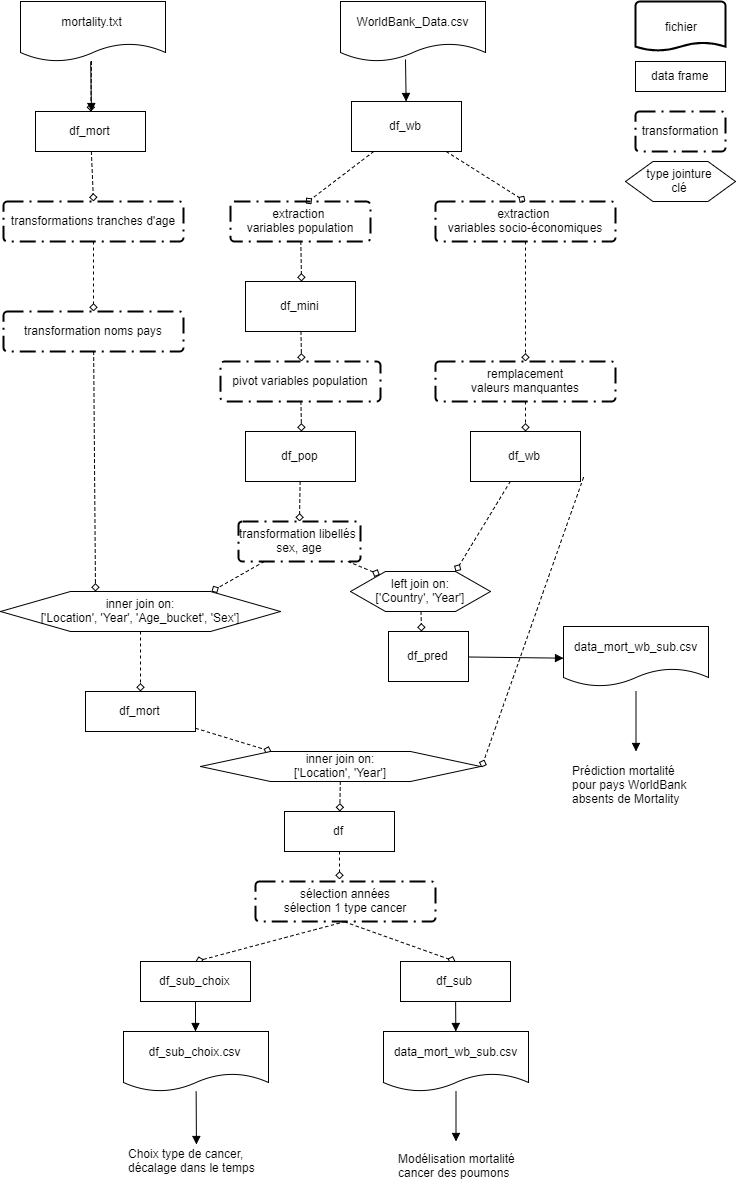

In [36]:
from IPython.display import Image
Image('Diagramme traitement base.png')